NOTE TO ALEX: use this and perhaps just ran RFs stuff with smaller dataset

# Homework 2
**Instructions:**
- Submit your code to github by the deadline.
- DO NOT change paths (-3 points).
- DO NOT submit data to github (-2 points).

In [1]:
import numpy as np
import pandas as pd

## Problem 1: log loss
**(a)** You have a classification problem with 3 classes: "cat", "dog", "bird". For your test observation is a "dog". Your model give you the following prediction for that observation (0.1, 0.5, 0.4). What is the accuracy? What is the log loss?

**(b)** Suppose that you are submitting to a Kaggle competition. You are solving a binary classification task being evaluated by log loss metric. You suspect train and test target distributions are different, you submit a constant predition of 0.3 and to the public LB and get a score of 1.01. Mean of target variable in train is 0.44. What is the mean of target variable in public part of test data? Explain how you derive the results.

In [3]:
# YOUR CODE HERE
#(a)
accuracy = 1.0 / 1.0
print("Accuracy is: {}".format(accuracy))

log_loss = - np.log(0.5)
print("Log Loss is: {}".format(log_loss))

Accuracy is: 1.0
Log Loss is: 0.6931471805599453


YOUR ANSWER HERE

In [5]:
# YOUR CODE HERE
log_loss = 1.1
pred_of_1 = 0.3
pred_of_0 = 1 - pred_of_1
# log_loss = (1 - mean) * log(1 - pred of 1) + mean * log(pred of 1)
mean = - (log_loss + np.log(pred_of_0)) / (np.log(pred_of_1) - np.log(pred_of_0))
print("Mean of target data in public part of test data: {}".format(mean))

Mean of target data in public part of test data: 0.8772889568275059


## Problem 2: AUC
Compute AUC score by hand with the formula explained in class for the following dataset.

In [6]:
d = pd.DataFrame({
        'prediction': [0.1, 0.5, 0.95, 0.99, 0.8, 0.4, 0.03, 0.44, 0.2],
        'y': [1, 0, 1, 1, 1, 1, 0, 0, 0]})
d

,prediction,y
0,0.10,1
1,0.50,0
2,0.95,1
3,0.99,1
4,0.80,1
5,0.40,1
6,0.03,0
7,0.44,0
8,0.20,0


AUC is the probability a randomly-chosen positive example is ranked more highly than a randomly-chosen negative example. It can be computed as the ratio of

$$1 - \frac{\text{number of pairs example wrongly ordered }}{\text{number of pairs (positive, negative)}}$$

In [7]:
# YOUR CODE HERE
def compute_AUC(df):
    pairs = 0
    correct_pairs = 0
    for i in range(len(d)):
        for j in range(i):
            if df.y[i] == df.y[j]:
                continue
            pairs += 1
            if df.prediction[i] > df.prediction[j] and df.y[i] > df.y[j]:
                correct_pairs += 1
            if df.prediction[i] < df.prediction[j] and df.y[i] < df.y[j]:
                correct_pairs += 1
    return correct_pairs / pairs

compute_AUC(d)

0.75

## Problem 3: Regularized mean (target) encoding for Avazu competition

For this problem you will implement a version of regularized mean encoding. We will be using the data on this Kaggle [compettion](https://www.kaggle.com/c/avazu-ctr-prediction).  

**Instructions:**
- Split data (training) into training and validation. Take the last week (7 days) of training set as validation.
- Implement regularized mean encoding for the training set using pandas.
- Implement mean encoding for the validation set

In [8]:
## Split train and validation 
# get sample data first
path = "avazu/"
!head -100000 $path/train > $path/train_sample.csv
!head -100000 $path/test > $path/test_sample.csv
data = pd.read_csv(path + "train_sample.csv")
test = pd.read_csv(path + "test_sample.csv")

In [9]:
def split_based_hour(data):
    """ Split data based on column hour.
    
    Use 20% of the date for validation.
    Inputs:
       data: dataframe from avazu
    Returns:
       train:
       val: 20% of the largest values of column "hour".
    """
    N = int(0.8*len(data))
    data = data.sort_values(by="hour")
    train = data[:N].copy()
    val = data[N:].copy()
    return train.reset_index(), val.reset_index()
train, val = split_based_hour(data)

### Regularized mean encoding 
Here is how you do mean encoding without regularization.

In [10]:
# Calculate a mapping: {device_type: click_mean}
mean_device_type = train.groupby('device_type').click.mean()
mean_device_type

device_type
0    0.224277
1    0.176116
4    0.069777
5    0.083333
Name: click, dtype: float64

In [11]:
# This is the global click mean
global_mean = train.click.mean()
global_mean

0.17477718471480894

In [12]:
train["device_type_mean_enc"] = train["device_type"].map(mean_device_type)
val["device_type_mean_enc"] = val["device_type"].map(mean_device_type)

In [13]:
train["device_type_mean_enc"].fillna(global_mean, inplace=True)
val["device_type_mean_enc"].fillna(global_mean, inplace=True)

In [14]:
# Print correlation
encoded_feature = val["device_type_mean_enc"].values
print(np.corrcoef(val["click"].values, encoded_feature)[0][1])

0.0530389229998


To do mean encoding with K-fold regularization you do the following:

* Run a 5-fold split on train data where `mean_device_type` is computed on 4/5 of the data and the encoding is computed on the other 1/5.
* To compute mean encoding on the validation data use the code similar to encoding without regularization. That is compute on all the training data and apply to the validation set.

In [15]:
from sklearn.model_selection import KFold

def reg_target_encoding(train, col = "device_type", splits=5):
    """ Computes regularize mean encoding.
    Inputs:
       train: training dataframe
       
    """
    # YOUR CODE HERE
    kf = KFold(splits)
    
    train[col + "_mean_enc"] = np.nan
    
    for a,b in kf.split(train):
        train_subset = train.loc[a]
        test_subset = train.loc[b]
        mean_device_type = train_subset.groupby(col).click.mean()
        train.loc[b,col + "_mean_enc"] = test_subset[col].map(mean_device_type)
    
    global_mean = train.click.mean()
    train[col + "_mean_enc"].fillna(global_mean, inplace=True)

In [16]:
reg_target_encoding(train) 
encoded_feature = train["device_type_mean_enc"].values
corr = np.corrcoef(train["click"].values, encoded_feature)[0][1]
assert(np.around(corr, decimals=4) == 0.0551)

In [17]:
def mean_encoding_test(test, train, col = "device_type"):
    """ Computes target enconding for test data.
    
    This is similar to how we do validation
    """
    # YOUR CODE HERE
    mean_device_type = train.groupby(col).click.mean()
    test[col + "_mean_enc"] = test[col].map(mean_device_type)
    
    global_mean = train.click.mean()
    test[col + "_mean_enc"].fillna(global_mean, inplace=True)

In [18]:
mean_encoding_test(test, train) 
encoded_feature_mean = test["device_type_mean_enc"].values.mean()
assert(np.around(encoded_feature_mean, decimals=4) == 0.177)

## Problem 4: Implement other features and fit a model (10 points)
* Implement a few more features, include:
   * day of the week and hour
   * mean encoding of some other features (at least two)
   * use plots and `value_counts()` to understand the data

* Fit a random forest (to the whole dataset)
   * Do hyperparameter tunning using your validation set
   * Report test and train log loss

In [19]:
types = {'id': str, 'click': np.uint8, 'hour': np.uint32, 'C1': np.uint32, 'banner_pos': np.uint32,
         'site_id': object, 'site_domain': object, 'site_category': object, 'app_id': object,
         'app_domain': object, 'app_category': object, 'device_id': object,
         'device_ip': object, 'device_model': object, 'device_type': object, 'device_conn_type': object,
         'C14': np.uint16, 'C15': np.uint16, 'C16': np.uint16, 'C17': np.uint16, 'C18': np.uint16, 'C19': np.uint16,
         'C20': np.uint16, 'C21': np.uint16}

In [20]:
test_types = {'id': str, 'hour': np.uint32, 'C1': np.uint32, 'banner_pos': np.uint32,
         'site_id': object, 'site_domain': object, 'site_category': object, 'app_id': object,
         'app_domain': object, 'app_category': object, 'device_id': object,
         'device_ip': object, 'device_model': object, 'device_type': object, 'device_conn_type': object,
         'C14': np.uint16, 'C15': np.uint16, 'C16': np.uint16, 'C17': np.uint16, 'C18': np.uint16, 'C19': np.uint16,
         'C20': np.uint16, 'C21': np.uint16}

In [21]:
def load_data():
    path = "avazu/"
    data = pd.read_csv(path + "train")
    test = pd.read_csv(path + "test")
    return data, test

In [22]:
# YOUR CODE HERE

In [24]:
def load_data_alex(types, test_types):
    path = "avazu/"
    data = pd.read_csv(path + "train", usecols=types.keys(), dtype=types)
    test = pd.read_csv(path + "test", usecols=test_types.keys(), dtype=test_types)
    return data, test

In [25]:
data, test = load_data_alex(types, test_types)
train, val = split_based_hour(data)

In [26]:
test_ids = test.id

### Part 1: Feature Engineering

**Mean Encodings:**

In [27]:
reg_target_encoding(train)
mean_encoding_test(val, train)
mean_encoding_test(test, train)

In [28]:
reg_target_encoding(train, 'site_category')
mean_encoding_test(val, train, 'site_category')
mean_encoding_test(test, train, 'site_category')

In [29]:
reg_target_encoding(train, 'device_conn_type')
mean_encoding_test(val, train, 'device_conn_type')
mean_encoding_test(test, train, 'device_conn_type')

**Date Parsing:**

In [30]:
train['hour'] = '20' + train['hour'].astype(str)
val['hour'] = '20' + val['hour'].astype(str)
test['hour'] = '20' + test['hour'].astype(str)

In [31]:
train['hour'] = pd.to_datetime(train.hour, format = '%Y%m%d%H')
val['hour'] = pd.to_datetime(val.hour, format = '%Y%m%d%H')
test['hour'] = pd.to_datetime(test.hour, format = '%Y%m%d%H')

In [32]:
train['dow'], train['hour of day'] = train.hour.dt.weekday, train.hour.dt.hour
val['dow'], val['hour of day'] = val.hour.dt.weekday, val.hour.dt.hour
test['dow'], test['hour of day'] = test.hour.dt.weekday, test.hour.dt.hour

In [33]:
train['year'], train['month'], train['day'] = train.hour.dt.year, train.hour.dt.month, train.hour.dt.day
val['year'], val['month'], val['day'] = val.hour.dt.year, val.hour.dt.month, val.hour.dt.day
test['year'], test['month'], test['day'] = test.hour.dt.year, test.hour.dt.month, test.hour.dt.day

### Part 2: EDA

In [34]:
%matplotlib inline

**Dates:**

In [35]:
train['hour'].describe()

count                32343173
unique                    192
top       2014-10-22 09:00:00
freq                   447783
first     2014-10-21 00:00:00
last      2014-10-28 23:00:00
Name: hour, dtype: object

In [36]:
val['hour'].describe()

count                 8085794
unique                     49
top       2014-10-30 04:00:00
freq                   347806
first     2014-10-28 23:00:00
last      2014-10-30 23:00:00
Name: hour, dtype: object

In [37]:
test['hour'].describe()

count                 4577464
unique                     24
top       2014-10-31 09:00:00
freq                   299162
first     2014-10-31 00:00:00
last      2014-10-31 23:00:00
Name: hour, dtype: object

So we find that, as per the Kaggle description, the test set consists of a single day. As we have divided up training-validation, the validation set consists of the two days prior and the training set is the 7 days before that.

**Total clicks:**

In [38]:
train.click.value_counts()

0    26797331
1     5545842
Name: click, dtype: int64

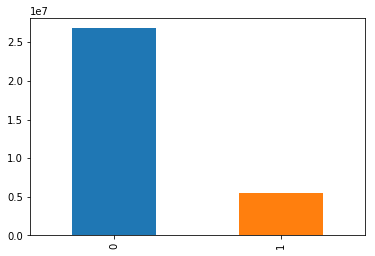

In [39]:
train.click.value_counts().plot.bar()

So we notice that the dataset is heavily inbalanced towards 'no click', with a ratio of roughly 5:1

**Looking at columnar structure:**

In [411]:
for c in train:
    print(c, ':', train[c].dtype.name)

index : int64
id : object
click : uint8
hour : datetime64[ns]
C1 : uint32
banner_pos : uint32
site_id : object
site_domain : object
site_category : object
app_id : object
app_domain : object
app_category : object
device_id : object
device_ip : object
device_model : object
device_type : object
device_conn_type : object
C14 : uint16
C15 : uint16
C16 : uint16
C17 : uint16
C18 : uint16
C19 : uint16
C20 : uint16
C21 : uint16
device_type_mean_enc : float64
site_category_mean_enc : float64
device_conn_type_mean_enc : float64
dow : int64
hour of day : int64
year : int64
month : int64
day : int64


In [40]:
for c in train:
    if train[c].dtype.name == 'object':
        print('Number of unique values in {} is: {}'.format(c,train[c].nunique()))

Number of unique values in id is: 32343173
Number of unique values in site_id is: 4551
Number of unique values in site_domain is: 7297
Number of unique values in site_category is: 26
Number of unique values in app_id is: 8094
Number of unique values in app_domain is: 539
Number of unique values in app_category is: 36
Number of unique values in device_id is: 2216415
Number of unique values in device_ip is: 5563626
Number of unique values in device_model is: 8036
Number of unique values in device_type is: 5
Number of unique values in device_conn_type is: 4


Note that `device_type` and `device_conn_type` have been manually added to list of category columns since we note their low cardinality in an initial examination

**Click rate by device type:**

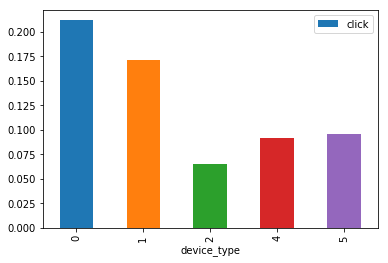

In [41]:
train.groupby('device_type', as_index = False).mean()[['device_type', 'click']].plot(x = 'device_type', y = 'click', kind = 'bar')

In [42]:
train.device_type.value_counts()

1    29804292
0     1807037
4      626896
5      104917
2          31
Name: device_type, dtype: int64

By far most clicks are through device type 1, another imbalanced dataset.

**Time of Day Effect:**

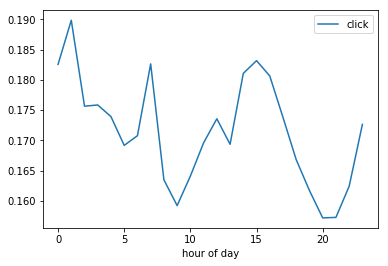

In [43]:
train.groupby('hour of day', as_index = False).mean().plot(x = 'hour of day', y = 'click')

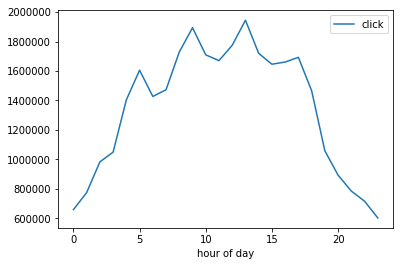

In [44]:
train.groupby('hour of day', as_index = False).count().plot(x = 'hour of day', y = 'click')

Click-through rates spike mid-afternoon and late at night, although there are vastly more observations in the middle of the day

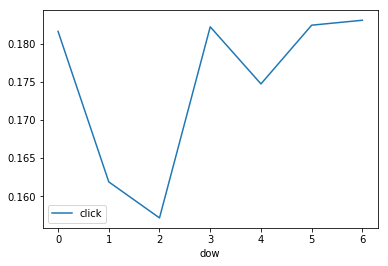

In [45]:
train.groupby('dow', as_index = False).mean().plot(x = "dow", y = "click")

Note that fewest clicks on Monday and Tuesday, but we only have one observation for each day of the week, so a small (the smallest) sample of distinct days.

### Part 3: Fit a Random Forest

From our EDA, we found that the DataFrame currently consists of numerical and category columns (no strings). We now require to numerically encode the categorical variables. For the low-cardinality categorical variables (`device_type` and `device_conn_type`), we will encode them using one-hot encoding, whereas the high-cardinality variables will be encoded as a continuous range, to avoid overfitting and to make use of any inherent structure in the ordering.

In [46]:
def one_hot_encodings(df):
    for c in ['device_type','device_conn_type']:
        df[c] = df[c].astype('category')
        for val in df[c].unique():
            df[c + '_' + str(val)] = (df[c] == val)
        df = df.drop(c, axis = 1)
    return df

In [47]:
train = one_hot_encodings(train)
val = one_hot_encodings(val)
test = one_hot_encodings(test)

In [48]:
from sklearn.preprocessing import LabelEncoder

def label_encodings(train, val, test):
    LEs = []
    for col in train:
        if train[col].dtype.name == 'object':
            LE = LabelEncoder()
            train[col] = train[col].fillna('NaN').astype('category')
            train[col] = LE.fit_transform(train[col])
            dic = dict(zip(LE.classes_, LE.transform(LE.classes_)))
            val[col] = val[col].map(dic).fillna(-1)
            test[col] = test[col].map(dic).fillna(-1)
            LEs.append(LE)
    return (train, val, test, LEs)

In [49]:
train, val, test, _ = label_encodings(train,val,test)

Dropping hour column:

In [50]:
train, val, test = train.drop("hour", axis = 1), val.drop("hour", axis = 1), test.drop("hour", axis = 1)

In [51]:
X_train, y_train = train.drop(["click","id", "index"], axis = 1), train["click"]
X_train = X_train.reindex(sorted(X_train.columns), axis=1)
X_val, y_val = val.drop(["click","id", "index"], axis = 1), val["click"]
X_val = X_val.reindex(sorted(X_val.columns), axis=1)
X_test = test.drop("id", axis = 1)
X_test = X_test.reindex(sorted(X_test.columns), axis=1)

**Fit a RF:**

In [52]:
from sklearn.ensemble import RandomForestClassifier

Hyper-parameter sets to choose from:

In [425]:
n_estimators = [5,10,15]

In [426]:
min_samples_leaf = [1,10,50]

In [427]:
max_depth = [None, 10, 20]

In [428]:
best_val_accuracy = 0
for x in n_estimators:
    for y in min_samples_leaf:
        for z in max_depth:
            m = RandomForestClassifier(n_jobs = -1, n_estimators = x, min_samples_leaf = y, max_depth = z)
            m.fit(X_train, y_train)
            accuracy = m.score(X_val, y_val)
            print("Accuracy is: {}. Params -- n_estimators = {}, min_samples_leaf = {} and max_depth = {}".format(accuracy, x, y, z))
            if accuracy > best_val_accuracy:
                best_val_accuracy = accuracy
                best_params = [x,y,z]
print("\nBest accuracy on the validation set ({}) is achieved with n_estimators = {}, min_samples_leaf = {} and max_depth = {}".format(best_val_accuracy, best_params[0], best_params[1], best_params[2]))

Accuracy is: 0.7557. Params -- n_estimators = 5, min_samples_leaf = 1 and max_depth = None
Accuracy is: 0.8306. Params -- n_estimators = 5, min_samples_leaf = 1 and max_depth = 10
Accuracy is: 0.7942. Params -- n_estimators = 5, min_samples_leaf = 1 and max_depth = 20
Accuracy is: 0.8339. Params -- n_estimators = 5, min_samples_leaf = 10 and max_depth = None
Accuracy is: 0.83465. Params -- n_estimators = 5, min_samples_leaf = 10 and max_depth = 10
Accuracy is: 0.833. Params -- n_estimators = 5, min_samples_leaf = 10 and max_depth = 20
Accuracy is: 0.835. Params -- n_estimators = 5, min_samples_leaf = 50 and max_depth = None
Accuracy is: 0.83595. Params -- n_estimators = 5, min_samples_leaf = 50 and max_depth = 10
Accuracy is: 0.8341. Params -- n_estimators = 5, min_samples_leaf = 50 and max_depth = 20
Accuracy is: 0.81445. Params -- n_estimators = 10, min_samples_leaf = 1 and max_depth = None
Accuracy is: 0.8319. Params -- n_estimators = 10, min_samples_leaf = 1 and max_depth = 10
Accu

Fitting optimal Random Forest:

In [53]:
RF = RandomForestClassifier(n_jobs = -1, n_estimators = 10, min_samples_leaf=10, max_depth=10)

In [54]:
RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [55]:
from sklearn.metrics import log_loss

Train set:

In [56]:
y_train_pred = RF.predict_proba(X_train)
y_train_pred = y_train_pred[:,1]
train_log_loss = log_loss(y_train, y_train_pred)
print(train_log_loss)

0.413238052332


Val Set:

In [ ]:
X_train.columns

In [58]:
X_val.columns

Index(['C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21',
       'app_category', 'app_domain', 'app_id', 'banner_pos', 'day',
       'device_conn_type_0', 'device_conn_type_2', 'device_conn_type_3',
       'device_conn_type_5', 'device_conn_type_mean_enc', 'device_id',
       'device_ip', 'device_model', 'device_type_0', 'device_type_1',
       'device_type_4', 'device_type_5', 'device_type_mean_enc', 'dow',
       'hour of day', 'month', 'site_category', 'site_category_mean_enc',
       'site_domain', 'site_id', 'year'],
      dtype='object')

In [57]:
y_valid_pred = RF.predict_proba(X_val)
y_valid_pred = y_valid_pred[:,1]
valid_log_loss = log_loss(y_val, y_valid_pred)
print(valid_log_loss)

ValueError: Number of features of the model must match the input. Model n_features is 36 and input n_features is 35 

Test Set:

In [ ]:
y_test_pred = RF.predict_proba(X_test)
y_test_pred = y_test_pred[:,1]

In [ ]:
submission_df = pd.DataFrame(y_test_pred)

In [ ]:
submission_df["id"] = test_ids

In [ ]:
submission_df.columns = ["click", "id"]

In [ ]:
submission_df[["id","click"]].to_csv("submission.csv", index = False)

In [ ]:
submission_df.head()

Reported Kaggle Score is: 0.42, ~10% off the leaders